# PiML Model Interpretability

- Data Pipeline

- Machine Learning Models: XGB and MLP

- Hyperparameter Tuning

- Post-hoc Explainability

- Inherently Interpretable Benchmark Models
  - FANOVA Models (XGB2 and GAMI-Net)
  - Inherent Interpretability
  - Monotonic Constraints



In [ ]:
!pip install piml

In [ ]:
from piml import Experiment
exp = Experiment()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## 1) Data Pipeline

In [ ]:
# Choose SimuCredit
exp.data_loader()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [ ]:
exp.eda()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [ ]:
# remove "Gender" and "Race" (Categorical)
exp.data_summary()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='<link rel="stylesheet" href="//stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.…

In [ ]:
exp.data_prepare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## 2) Machine Learning Models

In [ ]:
# Build XGBoost model with max_depth 3
from xgboost import XGBClassifier
model = XGBClassifier(max_depth=3, n_estimators=1000,
                      learning_rate=0.01, random_state=0)
exp.model_train(model, name="XGB-default")

exp.model_diagnose(model="XGB-default", show='accuracy_table')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.7033,0.7722,0.7265,0.5676,0.1931
Test,0.6890,0.7564,0.7153,0.5845,0.1997
Gap,-0.0143,-0.0158,-0.0112,0.0169,0.0066


In [ ]:
# Build ReLU Deep Neural Networks with [20]*3 hidden nodes
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=[20]*3,
                      activation="relu", random_state=0)
exp.model_train(model, name='MLP-default')

exp.model_diagnose(model="MLP-default", show='accuracy_table')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.6941,0.7576,0.7218,0.5803,0.1983
Test,0.6935,0.7554,0.7215,0.5867,0.2000
Gap,-0.0006,-0.0022,-0.0003,0.0064,0.0017


## 3) Hyperparameter Tuning

In [ ]:
# Hyperparameter Tuning with Grid Search
parameters = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8]}
result = exp.model_tune(model="XGB-default",
                        method="grid",
                        parameters=parameters,
                        metric=['AUC', 'LogLoss'],
                        test_ratio=0.4,
                        random_state=0)
result.data

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,Rank(by AUC),AUC,LogLoss,time
params,,,,
{'max_depth': 3},1,0.752090,0.588135,0.846186
{'max_depth': 2},2,0.751441,0.588816,0.706656
{'max_depth': 4},3,0.749131,0.591288,1.034846
{'max_depth': 5},4,0.747925,0.593690,3.041970
{'max_depth': 6},5,0.743697,0.599636,1.850384
{'max_depth': 7},6,0.741206,0.603746,2.345879
{'max_depth': 8},7,0.735205,0.612239,2.982974
{'max_depth': 1},8,0.732021,0.606960,0.547054


HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

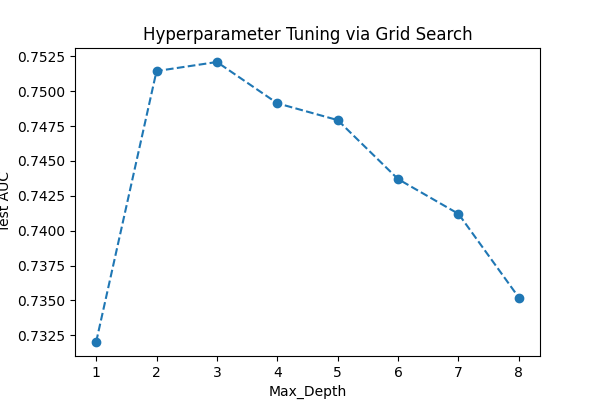

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, 1+result.data.shape[0]), result.cv_results_["mean_test_AUC"], '--o')
plt.xlabel("Max_Depth")
plt.ylabel("Test AUC")
plt.title("Hyperparameter Tuning via Grid Search")
plt.show()

In [ ]:
import scipy
parameter_space = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8],
                   'n_estimators': scipy.stats.randint(100, 2000),
                   'learning_rate': scipy.stats.loguniform(0.001, 1.0)}
result = exp.model_tune(model="XGB-default",
                        method="randomized",
                        parameters=parameter_space,
                        metric=["AUC", "LogLoss"],
                        n_runs=100,
                        test_ratio=0.4,
                        random_state=0)
# result.data

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

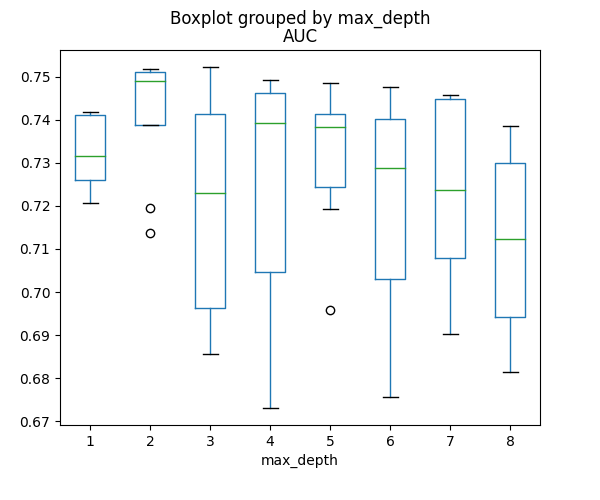

In [ ]:
import pandas as pd
df = pd.concat([pd.DataFrame(result.cv_results_['params']),
                pd.DataFrame(result.cv_results_["mean_test_AUC"], columns=["AUC"]),
                pd.DataFrame(result.cv_results_["mean_test_LogLoss"], columns=["LogLoss"])], axis=1)
df.boxplot(column=['AUC'], by='max_depth', grid=False, figsize=(6, 5))
plt.show()

In [ ]:
params = result.get_params_ranks(rank=1)
params

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

{'learning_rate': 0.009183150969807761, 'max_depth': 3, 'n_estimators': 1107}

In [ ]:
exp.model_train(XGBClassifier(**params), name="XGB-HPO")

exp.model_diagnose(model="XGB-HPO", show='accuracy_table')

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

,ACC,AUC,F1,LogLoss,Brier
,,,,,
Train,0.7023,0.7724,0.7255,0.5674,0.1930
Test,0.6903,0.7569,0.7159,0.5841,0.1995
Gap,-0.0121,-0.0155,-0.0096,0.0167,0.0065


## 4) Post-hoc Explainability

In [ ]:
exp.model_explain()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

## 5) Inherently Interpretable Benchmark Models

PiML includes a variety of inherently interpretable models based on the functional ANOVA framework:

- [GLM](https://github.wellsfargo.com/pages/Utilities-CMoR/Utilities-cmor-piml/_build/html/guides/models/glm.html): generalized linear model, a special form of GAM with linear main effects
- [GAM](https://github.wellsfargo.com/pages/Utilities-CMoR/Utilities-cmor-piml/_build/html/guides/models/gam.html): generalized additive model with non-linear main effects (splines)
- [XGB1](https://github.wellsfargo.com/pages/Utilities-CMoR/Utilities-cmor-piml/_build/html/guides/models/xgb1.html): XGB model with max depth of 1, a special form of GAM with piecewise-constant main effects
- [XGB2](https://github.wellsfargo.com/pages/Utilities-CMoR/Utilities-cmor-piml/_build/html/guides/models/xgb2.html): XGB model with max depth of 2, GAM with pairwise interactions (piecewise-constant)
- [EBM](https://github.wellsfargo.com/pages/Utilities-CMoR/Utilities-cmor-piml/_build/html/guides/models/ebm.html): explainable boosting machine, also GAM with pairwise interactions (piecewise-constant)
- [GAMI-Net](https://github.wellsfargo.com/pages/Utilities-CMoR/Utilities-cmor-piml/_build/html/guides/models/gaminet.html): GAM with pairwise interactions, using neural networks implementation
- [GAMI-Lin-Tree](https://arxiv.org/abs/2207.06950): GAM with pairwise interactions, based on boosted linear trees (WF-internal)

XGB2 / EBM / GAMI-Net / GAMI-Lin-Tree follow the generalized additive models with pairwise interactions:

\begin{equation}
g(E(y|\textbf{x})) = \mu + \sum\limits_{j} h_{j}(x_{j}) + \sum\limits_{j<k} f_{jk}(x_{j},x_{k}),
\end{equation}

where $\mu$ is the global intercept, each $h_{j}(x_{j})$ is a main effect, and each $f_{jk}(x_{j}, x_{k})$ is a pairwise interaction. To ensure model identifiability, main effects and pairwise interactions are assumed to be hierarchically orthogonal. Each main effect can be interpreted using 1D line plot or bar plot; each pairwise interaction can be visualized using 2D heatmaps or sliced line plots.

Note that the interpretability of XGB1, XGB2 and GAMI-Net can be easily enhanced with imposing monotone constraints.

In [ ]:
# Choose Models: XGB2, GAMI-Net (default config)
exp.model_train()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

### Inherent Interpretability

In [ ]:
exp.model_interpret()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

### Monotonic Constraints

In [ ]:
# Choose Model: XGB2-Mono (n_estimators = 1000, eta = 0.01), GAMI-Net-Mono
# Feature_increasing =  "Balance",
# Feature_decreasing =  "Utilization",
exp.model_train()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

<IPython.core.display.Javascript object>

In [ ]:
# Choose XGB2-Mono, GAMI-Net
exp.model_interpret()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…

In [ ]:
# Choose XGB-default, XGB2, GAMI-Net-Mono: Overfit (Delinquency, AUC), Robustness (noise step = 0.05)
exp.model_compare()

HTML(value='\n        <style>\n\n        .left-label {\n            width: 30%;\n        }\n\n        .card-pa…